# Happiest Cities - Data Cleaning

## Table of Contents

1. [Foursquare gridsearch](#gridsearch)
    
2. [...](#...)

In [110]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re

import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession, SQLContext, types, Row, DataFrame
from pyspark.sql.functions import isnan, max as F_max, col, struct, row_number, udf
from pyspark.sql.window import Window

import geopandas as gpd
# from googletrans import Translator

sns.set()

## Compile master dataset
<a id="gridsearch"/>

In [6]:
# Load happiness ratings for city set
ratings = pd.read_csv('data/cities-happiness.csv',index_col=0)
ratings

,avg_happiness_rating
city,
Tashkent,8.390
San Miguelito,8.372
San Jose,8.347
Accra,8.297
Panama City,8.286
...,...
Delhi,5.032
Beirut,4.760
Port-au-Prince,4.653


## Load gridsearch venue datasets with Spark

In [15]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("cities_happiness") \
    .getOrCreate()
spark

In [20]:
ratings_index = ratings.index
ratings_index

Index(['Tashkent', 'San Miguelito', 'San Jose', 'Accra', 'Panama City',
       'Denmark', 'Copenhagen', 'Helsinki', 'Atlanta', 'Freetown',
       ...
       'Mashhad', 'Tehran', 'Alexandria', 'Athens', 'Sanaa', 'Delhi', 'Beirut',
       'Port-au-Prince', 'Gaza', 'Kabul'],
      dtype='object', name='city', length=186)

In [68]:
# Manually adjust filenames
ratings_index = ['Panama' if x=='Panama City' else x for x in ratings_index]
ratings_index = ['Toronto' if x=='Toronto Metro' else x for x in ratings_index]
ratings_index = ['Lima' if x=='Lima Metro' else x for x in ratings_index]
ratings_index = ['Bogot' if x=='Bogota' else x for x in ratings_index]
ratings_index = ['SoPaulo' if x=='Sao Paulo' else x for x in ratings_index]
ratings_index = ['NewYorkCity' if x=='New York' else x for x in ratings_index]
ratings_index.remove('Kuwait City')
ratings_index.remove('Asuncion Metro')
ratings_index.remove('Cape Town')
ratings_index = ['Bangkok' if x=='Metro Bangkok' else x for x in ratings_index]
ratings_index = ['Manila' if x=='Metro Manila' else x for x in ratings_index]
ratings_index.remove('Cape Town')
ratings_index.remove('Vientiane/Vianchan')
ratings_index.remove('Antananarivo')
ratings_index.remove('Gaborone')
ratings_index = ['SaintPetersburg' if x=='St. Petersburg' else x for x in ratings_index]
ratings_index = ['HoChiMinhCity' if x=='Ho Chi Minh' else x for x in ratings_index]
ratings_index.remove('Lahore')
ratings_index.remove('Sarajevo')
ratings_index = ['KabulCenter' if x=='Kabul' else x for x in ratings_index]

In [58]:
len(ratings_index)

180

In [69]:
# Read city venues datasets compiled from Foursquare API

files = [f"data/foursquare_gridsearch/{re.sub('[^A-Za-z0-9]+', '', c)}_grid_venues.csv" for c in ratings_index]
df = spark.read.csv(files, header=True)
df.cache()
df.show(5)

+---+-------+--------------------+--------------+------------------+------------------+---------+
|_c0|   City|               Venue|Venue Category|    Venue Latitude|   Venue Longitude|Grid Item|
+---+-------+--------------------+--------------+------------------+------------------+---------+
|  0|Bangkok|Steak Today (สเต็...|    Steakhouse|13.648967605964232|100.34615752411233|        0|
|  1|Bangkok|Nuannoradit Witta...|   High School|13.646132610937556|100.34641518180436|        0|
|  2|Bangkok|  เตี๋ยวหมูกรอบต้มยำ|          null|          13.64934|        100.349163|        0|
|  3|Bangkok|          ร้านไก่ทอด|          null|         13.649114|100.34931421279616|        0|
|  4|Bangkok|       P.S.C Bangbon|          null|         13.647186|        100.346601|        0|
+---+-------+--------------------+--------------+------------------+------------------+---------+
only showing top 5 rows



In [72]:
# Examine number of venues fetched
df.count()

980431

## Data cleaning and exploration

In [73]:
# Drop unneeded columns
cities_venues_df = df.drop('_c0').drop('Grid Item')
cities_venues_df

DataFrame[City: string, Venue: string, Venue Category: string, Venue Latitude: string, Venue Longitude: string]

In [74]:
# Drop duplicates

cities_venues_df = cities_venues_df.dropDuplicates()
cities_venues_df.count()

964555

In [75]:
# Require venues have a name and coordinates

cities_venues_df = cities_venues_df.dropna(subset=['City', 'Venue', 'Venue Latitude', 'Venue Longitude'])
cities_venues_df.count()

964438

In [76]:
# Replace Venue Category missing values by scanning for other (Venue, Venue Category) pairs

# Show number of missing Venue Category values
cities_venues_df.filter(cities_venues_df['Venue Category'].isNull()).count()

93055

In [77]:
venues_filler_df = cities_venues_df\
                    .drop('City')\
                    .drop('Venue Latitude')\
                    .drop('Venue Longitude')\
                   .filter(cities_venues_df['Venue'].isNull()==False)\
                   .filter(cities_venues_df['Venue Category'].isNull()==False)\
                    .distinct()
venues_filler_df.take(5)

[Row(Venue='NYC Beach Bus', Venue Category='Bus Line'),
 Row(Venue='PS 111 Seton Falls', Venue Category='School'),
 Row(Venue='Mom’s Touch', Venue Category='Fried Chicken Joint'),
 Row(Venue='Modulo De Licencias Y Control Vehicular', Venue Category='Government Building'),
 Row(Venue='喜多見郵便局', Venue Category='Post Office')]

In [78]:
grouped = (venues_filler_df
           .withColumnRenamed('Venue Category', 'Cat')
           .groupby(['Venue', 'Cat'])
           .count()
           .alias('counts')
          )
grouped.take(5)

[Row(Venue='NYC Beach Bus', Cat='Bus Line', count=1),
 Row(Venue='PS 111 Seton Falls', Cat='School', count=1),
 Row(Venue='Mom’s Touch', Cat='Fried Chicken Joint', count=1),
 Row(Venue='Modulo De Licencias Y Control Vehicular', Cat='Government Building', count=1),
 Row(Venue='喜多見郵便局', Cat='Post Office', count=1)]

In [79]:
# Group by Venue, find mode of Venue Category
matcher = (grouped
           .groupBy('Venue')
          .agg(F_max(struct(col('count'),
                           col('Cat'))
                    ).alias('max'))
          .select(col('Venue'), col('max.Cat')))
matcher.cache()
matcher.show(5)

+--------------------+--------------------+
|               Venue|                 Cat|
+--------------------+--------------------+
|"""Penki kontinen...|      General Travel|
|      """Акваріум"""|College Residence...|
|"""Результат"" це...|            Building|
|"Banderillas ""La...|          Food Stand|
|"Biblioteca UAM C...|     College Library|
+--------------------+--------------------+
only showing top 5 rows



In [80]:
matcher.count()

784547

In [81]:
filled = cities_venues_df.join(matcher, on="Venue", how='left')
filled.cache()
filled.show(10)

+--------------------+-----------+--------------------+------------------+------------------+--------------------+
|               Venue|       City|      Venue Category|    Venue Latitude|   Venue Longitude|                 Cat|
+--------------------+-----------+--------------------+------------------+------------------+--------------------+
|"""Penki kontinen...|    Vilnius|      General Travel|54.717213101646394|  25.2891408517243|      General Travel|
|      """Акваріум"""|       Kiev|College Residence...|         50.390217|         30.510293|College Residence...|
|      """Акваріум"""|       Kiev|College Residence...|         50.388733|         30.510668|College Residence...|
|"""Результат"" це...|     Almaty|            Building| 43.22220572268064| 76.89824821719338|            Building|
|"Banderillas ""La...|Mexico City|          Food Stand|         19.375896|        -99.052559|          Food Stand|
|"Biblioteca UAM C...|Mexico City|     College Library|19.351818364557786|-99.28

In [82]:
@udf("string")
def replace_category(x,y):
    return y if ((not x) | (x == "null")) else x

filled = (filled
     .withColumn('Category', replace_category(filled['Venue Category'], filled.Cat))
     .drop('Venue Category')
     .drop('Cat')
    )
filled.cache()
filled.show(5)

+--------------------+-----------+------------------+-----------------+--------------------+
|               Venue|       City|    Venue Latitude|  Venue Longitude|            Category|
+--------------------+-----------+------------------+-----------------+--------------------+
|"""Penki kontinen...|    Vilnius|54.717213101646394| 25.2891408517243|      General Travel|
|      """Акваріум"""|       Kiev|         50.390217|        30.510293|College Residence...|
|      """Акваріум"""|       Kiev|         50.388733|        30.510668|College Residence...|
|"""Результат"" це...|     Almaty| 43.22220572268064|76.89824821719338|            Building|
|"Banderillas ""La...|Mexico City|         19.375896|       -99.052559|          Food Stand|
+--------------------+-----------+------------------+-----------------+--------------------+
only showing top 5 rows



In [92]:
# TODO look at other ways of filling null venue categories - Drop for now

# saturated.drop(saturated['Category'].isNull()).count()
filled = filled.filter(filled['Category'].isNull()==False)
filled.count()

878278

In [93]:
# Require cities have Foursquare saturation (at least 50 venues)

saturated = filled.groupby('City').count().sort('count', ascending=False).filter('count>50')
saturated.show(10)

+-------------+-----+
|         City|count|
+-------------+-----+
|      Bangkok|49367|
|  Mexico City|41147|
|      Denmark|35343|
|    São Paulo|32342|
|        Tokyo|28366|
|    Singapore|27668|
|New York City|27385|
|        Izmir|25180|
|       Moscow|23165|
|        Seoul|22811|
+-------------+-----+
only showing top 10 rows



In [94]:
saturated_cities_list = [r.City for r in saturated.collect()]
saturated_cities_list

['Bangkok',
 'Mexico City',
 'Denmark',
 'São Paulo',
 'Tokyo',
 'Singapore',
 'New York City',
 'Izmir',
 'Moscow',
 'Seoul',
 'Istanbul',
 'Israel',
 'Ankara',
 'London',
 'Ho Chi Minh City',
 'Sydney',
 'Tunis',
 'Bogotá',
 'Shanghai',
 'Beijing',
 'Budapest',
 'Saint Petersburg',
 'Cyprus',
 'Panama',
 'Madrid',
 'Los Angeles',
 'Toronto',
 'Kiev',
 'Incheon',
 'Busan',
 'Daegu',
 'Houston',
 'Hong Kong',
 'Delhi',
 'Hanoi',
 'Dubai',
 'Guangzhou',
 'Taipei',
 'Paris',
 'Chicago',
 'Auckland',
 'Buenos Aires',
 'Prague',
 'Bucharest',
 'Vienna',
 'Minsk',
 'Belgrade',
 'Philadelphia',
 'Tehran',
 'Riga',
 'Barcelona',
 'Washington, D.C.',
 'Dallas',
 'Abu Dhabi',
 'Nairobi',
 'Karachi',
 'Sofia',
 'Cairo',
 'Colombo',
 'Helsinki',
 'Oslo',
 'Baku',
 'Lisbon',
 'Yangon',
 'Casablanca',
 'Tashkent',
 'Almaty',
 'Zagreb',
 'Guatemala City',
 'San Jose',
 'San Salvador',
 'Ljubljana',
 'Cork',
 'Phnom Penh',
 'Doha',
 'Dublin',
 'Khartoum',
 'Ulaanbaatar',
 'Tegucigalpa',
 'Bishkek',
 

In [95]:
len(saturated_cities_list)

154

In [96]:
saturated = filled.filter(col("City").isin(saturated_cities_list))
saturated.count()

877933

## Explore compiled dataset

In [97]:
# Explore cities
cities = saturated.groupby('City').count()
cities.cache()
sorted_cities = cities.sort('count', ascending=False)
sorted_cities.show(10)

+-------------+-----+
|         City|count|
+-------------+-----+
|      Bangkok|49367|
|  Mexico City|41147|
|      Denmark|35343|
|    São Paulo|32342|
|        Tokyo|28366|
|    Singapore|27668|
|New York City|27385|
|        Izmir|25180|
|       Moscow|23165|
|        Seoul|22811|
+-------------+-----+
only showing top 10 rows



In [98]:
sorted_cities.count()

154

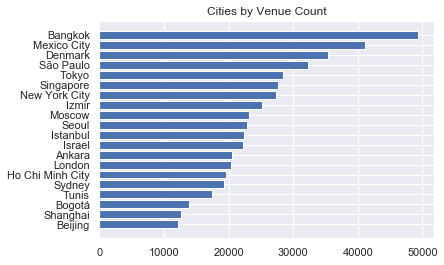

In [99]:
top_cities = [(c.City,c['count']) for c in sorted_cities.take(20)]
x,y = zip(*top_cities)
plt.barh(x,y)
plt.title('Cities by Venue Count')
plt.gca().invert_yaxis()
plt.show()

In [100]:
categories = saturated.groupby('Category').count()
sorted_categories = categories.sort('count', ascending=False)
sorted_categories.show(10)

+--------------------+-----+
|            Category|count|
+--------------------+-----+
|              Office|33684|
|Residential Build...|31481|
|                Café|20980|
|            Building|20231|
|                Road|14758|
|  Salon / Barbershop|14522|
|         Coffee Shop|11346|
|          Restaurant|11071|
|             Factory|10829|
|                Bank|10351|
+--------------------+-----+
only showing top 10 rows



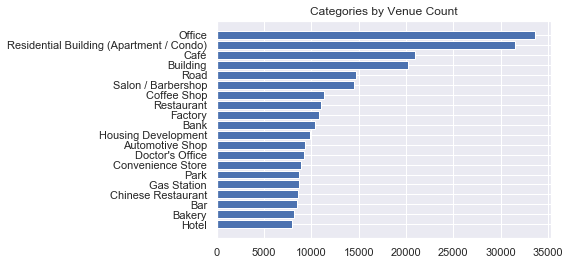

In [101]:
top_categories = [(str(c.Category),c['count']) for c in sorted_categories.take(20)]
x,y = zip(*top_categories)
plt.barh(x,y)
plt.title('Categories by Venue Count')
plt.gca().invert_yaxis()
plt.show()

In [102]:
venues = saturated.groupby('Venue').count().sort('count', ascending=False).cache()
venues.show(10)

+--------------------+-----+
|               Venue|count|
+--------------------+-----+
|            7-Eleven|  844|
|          McDonald's|  825|
|               Shell|  678|
|              Subway|  655|
|           Starbucks|  589|
|         Burger King|  388|
|7-Eleven (เซเว่น ...|  371|
|             Dunkin'|  355|
|                 KFC|  354|
|  Starbucks (星巴克)|  332|
+--------------------+-----+
only showing top 10 rows



In [103]:
venues.count()

784251

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3595 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3623 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3656 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3609 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3629 missing from current

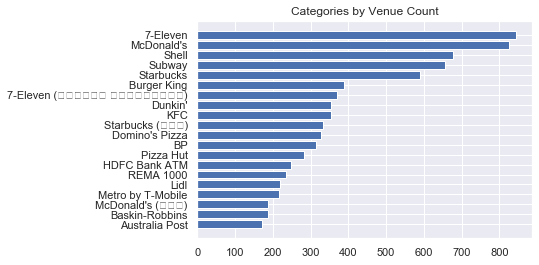

In [104]:
top_venues = [(str(c.Venue),c['count']) for c in venues.take(20)]
x,y = zip(*top_venues)
plt.barh(x,y)
plt.title('Categories by Venue Count')
plt.gca().invert_yaxis()
plt.show()

In [66]:
# TODO: Clean Venues list to match Starbucks(blahblah) to Starbucks

## Save Count and Frequency outputs

In [105]:
saturated.show(5)

+--------------------+-----------+------------------+-----------------+--------------------+
|               Venue|       City|    Venue Latitude|  Venue Longitude|            Category|
+--------------------+-----------+------------------+-----------------+--------------------+
|"""Penki kontinen...|    Vilnius|54.717213101646394| 25.2891408517243|      General Travel|
|      """Акваріум"""|       Kiev|         50.390217|        30.510293|College Residence...|
|      """Акваріум"""|       Kiev|         50.388733|        30.510668|College Residence...|
|"""Результат"" це...|     Almaty| 43.22220572268064|76.89824821719338|            Building|
|"Banderillas ""La...|Mexico City|         19.375896|       -99.052559|          Food Stand|
+--------------------+-----------+------------------+-----------------+--------------------+
only showing top 5 rows



In [106]:
counted_venues = saturated.groupBy("City").pivot("Category").count()
counted_venues.count()

154

In [107]:
counted_df = counted_venues.toPandas()
counted_df

,City,"Богданов и партнеры""""""",""""" Сары Озон""""","""""dakineshop.ru""""""","117""""""","12""""""","13""""""","17""""""","18""""""","34""""""",...,Zoo,Zoo Exhibit,Çöp Şiş Place,"Банкомат 24/7""","Ришон ле Цион""","д.24""""""","не Дай Другим""""""","площадка #2""","студия звукозаписи.""","חולון"""
0,Chisinau,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Casablanca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Cairo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Ulaanbaatar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Guangzhou,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,Boston,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150,Bogotá,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151,Izmir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,9.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,Shanghai,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
counted_df.set_index('City', drop=True, inplace=True)
counted_df

,"Богданов и партнеры""""""",""""" Сары Озон""""","""""dakineshop.ru""""""","117""""""","12""""""","13""""""","17""""""","18""""""","34""""""","38""""""",...,Zoo,Zoo Exhibit,Çöp Şiş Place,"Банкомат 24/7""","Ришон ле Цион""","д.24""""""","не Дай Другим""""""","площадка #2""","студия звукозаписи.""","חולון"""
City,,,,,,,,,,,,,,,,,,,,,
Chisinau,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Casablanca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cairo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ulaanbaatar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Guangzhou,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Boston,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bogotá,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Izmir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,9.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
for c in counted_df.index:
    try:
        filename = re.sub('[^A-Za-z0-9]+', '', c)
        geo_df = gpd.read_file(f'data/foursquare_gridsearch/{filename}.geojson')
        geo_df_copy = geo_df.copy()
        geo_df_meters = geo_df_copy.to_crs({'init': 'epsg:3857'})
        area_sqkm = geo_df_meters.geometry.area[0]/10**6
        counted_df.loc[c, 'area_sqkm'] = area_sqkm
    except:
        print('unable to find file for '+str(c))

In [112]:
counted_df

,"Богданов и партнеры""""""",""""" Сары Озон""""","""""dakineshop.ru""""""","117""""""","12""""""","13""""""","17""""""","18""""""","34""""""","38""""""",...,Zoo Exhibit,Çöp Şiş Place,"Банкомат 24/7""","Ришон ле Цион""","д.24""""""","не Дай Другим""""""","площадка #2""","студия звукозаписи.""","חולון""",area_sqkm
City,,,,,,,,,,,,,,,,,,,,,
Chisinau,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,266.051151
Casablanca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,310.621941
Cairo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4016.966775
Ulaanbaatar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8897.100096
Guangzhou,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8788.365017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Boston,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,451.135580
Bogotá,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,630.268361
Izmir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26592.805085


In [114]:
counted_df.area_sqkm.value_counts(dropna=False)

40.425972       2
7237.072708     1
2113.377878     1
504.814659      1
286.399288      1
               ..
1021.651395     1
752.635345      1
338.552288      1
43561.153957    1
1823.834453     1
Name: area_sqkm, Length: 153, dtype: int64

In [115]:
counted_df.to_csv('data/counted_happiness_venues.csv')